# Markov Chains and Network Centrality

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
# import libraries
import numpy as np
import matplotlib as mp
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
from importlib import reload
from datetime import datetime
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import networkx as nx
from IPython.display import Image
from IPython.display import display_html
from IPython.display import display
from IPython.display import Math
from IPython.display import Latex
from IPython.display import HTML
import slideUtilities as sl
print('')

In [2]:
%%html
<style>
 .container.slides .celltoolbar, .container.slides .hide-in-slideshow {
    display: None ! important;
}
</style>

%Set up useful MathJax (Latex) macros.
%See http://docs.mathjax.org/en/latest/tex.html#defining-tex-macros
%These are for use in the slideshow
$\newcommand{\mat}[1]{\left[\begin{array}#1\end{array}\right]}$
$\newcommand{\vx}{{\mathbf x}}$
$\newcommand{\hx}{\hat{\mathbf x}}$
$\newcommand{\vbt}{{\mathbf\beta}}$
$\newcommand{\vy}{{\mathbf y}}$
$\newcommand{\vz}{{\mathbf z}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\vu}{{\mathbf u}}$
$\newcommand{\vv}{{\mathbf v}}$
$\newcommand{\vw}{{\mathbf w}}$
$\newcommand{\col}{{\operatorname{Col}}}$
$\newcommand{\nul}{{\operatorname{Nul}}}$
$\newcommand{\vb}{{\mathbf b}}$
$\newcommand{\va}{{\mathbf a}}$
$\newcommand{\ve}{{\mathbf e}}$
$\newcommand{\setb}{{\mathcal{B}}}$
$\newcommand{\rank}{{\operatorname{rank}}}$
$\newcommand{\vp}{{\mathbf p}}$

An important question in the analysis of networks is to understand the relative "importance" of the nodes in the network.

For example:

* in a social network, who are the most influential individuals?
* in the Web, which pages are more informative?
* in road network, which intersections are most heavily used?


These are often termed questions of __centrality__ (or __prestige__).

Today we'll study metrics for these notions.   We'll work with a graph $G$.

Random walks play an important role in the concept of "status" node centrality:
    
- "Status" Centrality: A central node is connected to other central nodes.

In [4]:
Gk=nx.karate_club_graph()
np.random.seed(2)
pos = nx.spring_layout(Gk)

/Users/evimaria/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


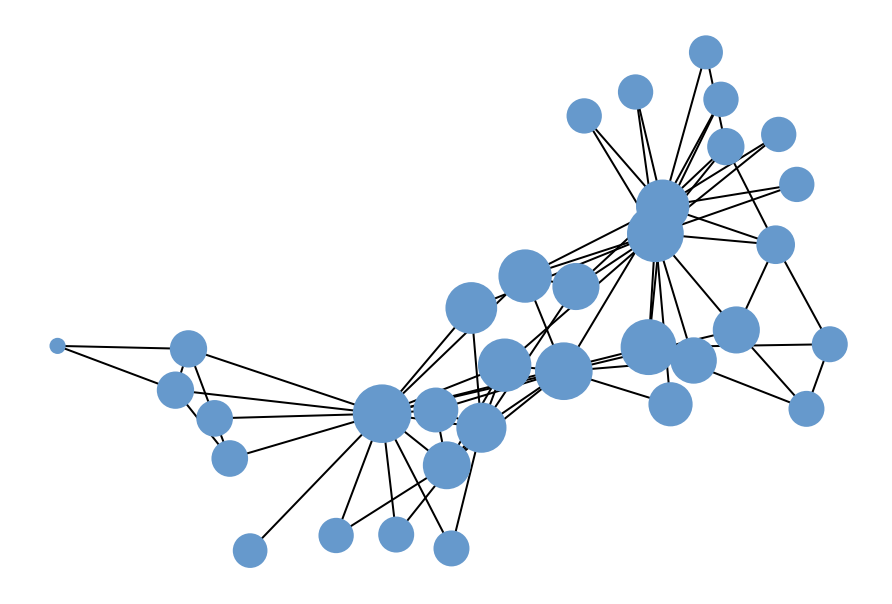

In [5]:
# plotting the graph 
cent = np.array(list(nx.closeness_centrality(Gk).values()))
scaler = MinMaxScaler((50,800))
scaledC = scaler.fit_transform(cent[:,np.newaxis])
nx.draw(Gk, node_size=scaledC, pos=pos, node_color='#6699cc')

## Status Centrality

In the context of status centrality, one often talks of "prestige" rather than "centrality."  But the concepts are related.

The idea of __status__ centrality is that "high status" nodes are those that are connected to "high status" nodes.

If you think this definition is circular, you are right!

Nonetheless, it leads to some metrics that are quite well defined and not hard to compute.

__Eigenvector Centrality.__

Our first form of status centrality derives directly from the intuitive notion that high status nodes are those that associate with other high status nodes.

So in this case we say that the centrality of a node is just the sum of the centrality of its neighbors, times some factor.

That is,

$$ \mathbf{v}(i) = 1/\lambda \sum_{(i,j) \in E} \mathbf{v}(j). $$

This defines a recursive formulation may or may not converge, depending on $\lambda$.

In fact, we can rewrite this in terms of the adjacency matrix $A$ where $A(i,j) = 1$ if $(i,j) \in E$.

$$\lambda \,\mathbf{v}(i) = \sum_j A(i,j) \mathbf{v}(j).$$

If we think of $\mathbf{v}$ as a column vector (say, $\mathbf e$), then this is:

$$ A{\mathbf e} = \lambda {\mathbf e}$$

which tells us that $\mathbf e$ must be an eigenvector of $A$.

There is a good argument for choosing $\lambda$ as the largest eigenvalue of $A$.   In this case all the entries in $\mathbf e$ will have the same sign.

By convention we use the absolute value of the entries of $\mathbf e$ as each node's __eigenvector centrality__.

Let's check them out on our test case, the karate club:

/Users/evimaria/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


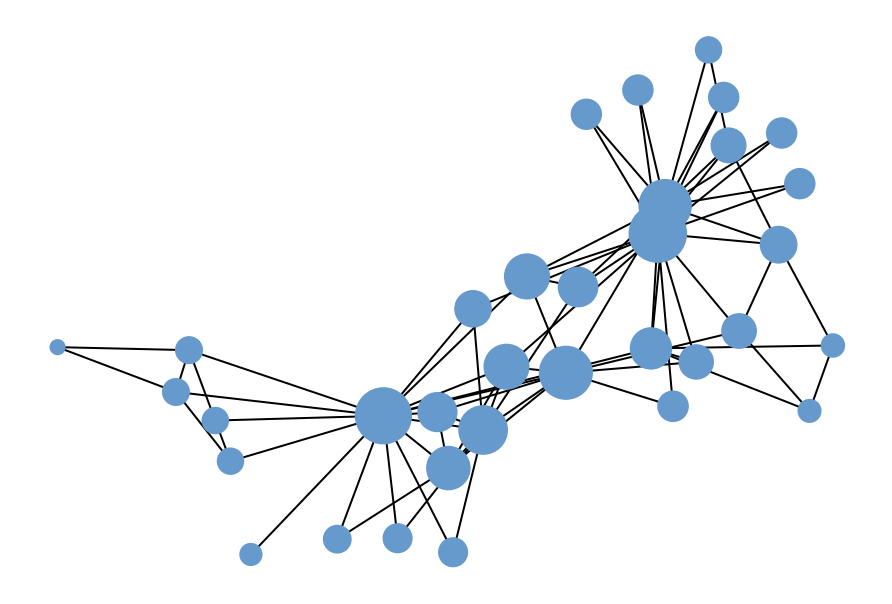

In [6]:
# plotting the graph 
cent = np.array(list(nx.eigenvector_centrality(Gk).values()))
scaler = MinMaxScaler((50,800))
scaledC = scaler.fit_transform(cent[:,np.newaxis])
nx.draw(Gk, node_size=scaledC, pos=pos, node_color='#6699cc')

Notice how the large nodes form an "inner circle" of this social network.

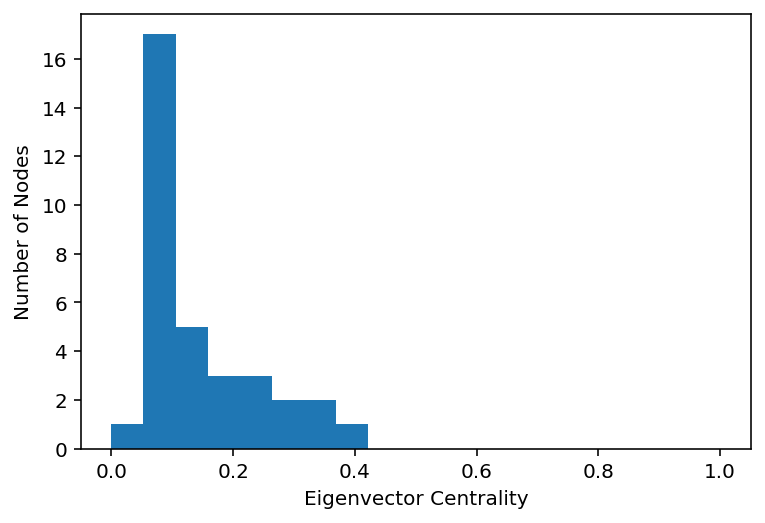

In [7]:
plt.hist(cent,bins=np.linspace(0,1,20))
plt.xlabel('Eigenvector Centrality')
_=plt.ylabel('Number of Nodes')

__Pagerank Centrality.__

So far, the measures we have been talking about could apply to either directed or undirected graphs.

When one focuses on directed graphs, some new ideas can be applied.

An important example concerns the Web: a link is a __directed__ edge from one Web page to another.

To set the stage for understanding Pagerank: 

In the mid to late 1990's, there were literally dozens of search engines for the Web.
    
At present, most of them are no longer in existence, because Google emerged in 1998 and came to dominate Web search almost overnight.

How did this happen?

As background: a typical search engine uses a two-step process to retrieve pages related to a user’s query. 

In
the first step, basic text processing is done to find all documents that contain the query terms. 
Due to the massive size of the Web, this first step can result in many thousands of retrieved pages related to the query.   

Some of these pages are important, but most are not.

The problem that Google solves better than the search engines of the mid 1990’s concerns the __ordering__ in which the resulting search results are presented.  This is the crucial factor in utility.  A user wants to find the best item at the top of the search results.

By displaying the most relevant pages at the top of the list returned each query, Google makes its search results very useful. The algorithm that gave Google this advantage is called Pagerank.

__The Insight__

Around 1998, the limitations of standard search engines, which just used term frequency, we becoming apparent.   A number of researchers were thinking about using additional sources of information to "rate" pages.

The key idea that a number of researchers hit on was this: _links are endorsements._  

When a first page contains a link to a second page, that is an indication that the author of the first page thinks the second page is worth looking at.  If the first and second pages both contain the same query terms, it is likely that the second page is an important page with respect to that query term.

Consider a set of web pages, for a single query term (say "car manufacturers") with this linking structure:

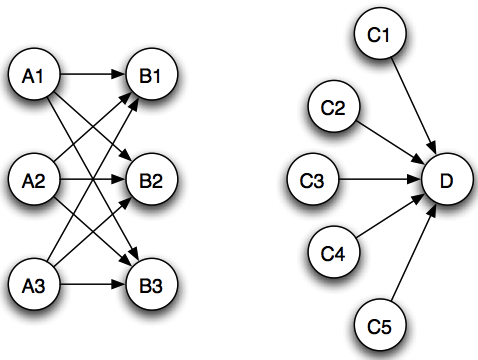

In [12]:
sl.hide_code_in_slideshow()
display(Image("figs/hub-authority.png", width=350))

It may be clear that the links between pages contain useful information.  But what is the best way to extract that information in the form of rankings?

Here is the strategy that Brin and Page used:

From _“The PageRank citation ranking: Bringing order to the Web”_ (1998):
> PageRank can be thought of as a model of user behavior. We assume there is a “random surfer” who is given a web page at random and keeps clicking on links, never hitting “back” but eventually gets bored and starts on another random page. The probability that the random surfer visits a page is its PageRank.

## PageRank

There are many ways to make use of the link structure to infer which pages are most important to return at the top of the search results.  (There was a lot of experimentation in the late 1990s with various methods).

A simple method is just to consider a page is "important" if many "important" pages link to it.

More precisely, this definition of "importance" is:

$$\mbox{Importance of page $k$} = \sum_j \mbox{(Importance of page $j$)}\cdot\mbox{(Probability of going from page $j$ to page $k$.)}$$

This can be captured in terms of a random walk.  

Now we are ready to understand what Page and Brin were saying in 1998:

> PageRank can be thought of as a model of user behavior. We assume there is a “random surfer” who is given a web page at random and keeps clicking on links, never hitting “back” but eventually gets bored and starts on another random page. The probability that the random surfer visits a page is its PageRank.

Intuitively, the a random surfer should spend more time at "important" pages and less time at unimportant pages.

The way to interpret this precisely is:

1) Form the graph that encodes the connections between Web pages that are retrieved for a particular query. 

2) Construct a Markov chain that corresponds to a random walk on this graph.

3) Rank-order the pages according to their probability in the Markov chain's steady state.

So let's try to make this work and see what happens.

__Example.__   Assume a set of Web pages have been selected based on a text query, eg, pages related to "personal 737 jets."

These pages have various links between them, as represented by this graph:

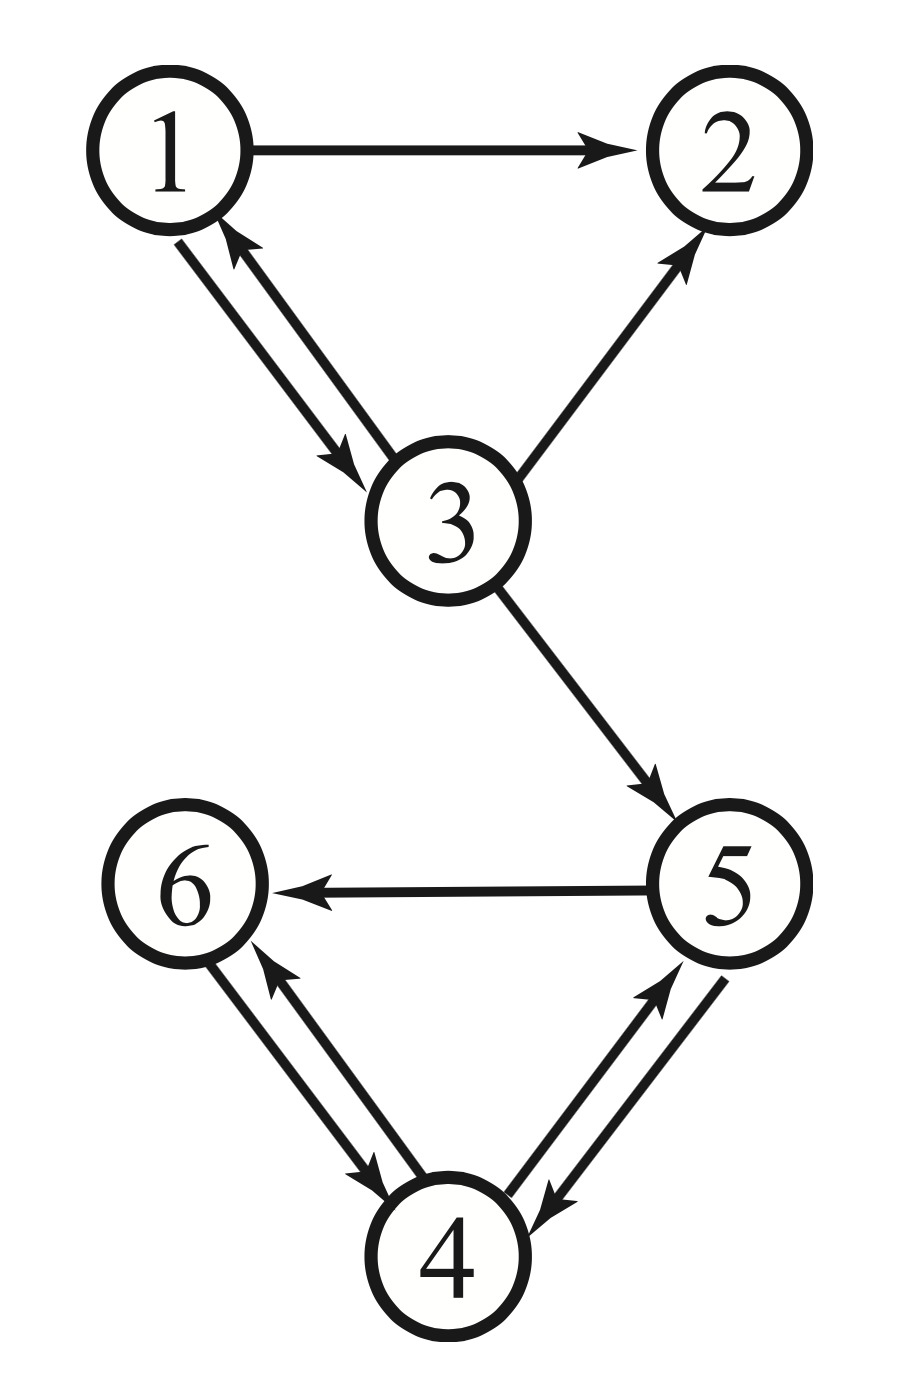

In [19]:
sl.hide_code_in_slideshow()
display(Image("figs/deeper-pagerank-fig.jpg", width=250))

Let us try to construct the unique steady-state distribution for a random walk on this graph, if it exists.  That is, we will construct the PageRank for this set of Web pages.

__Solution.__

The key question we must ask is __whether a unique steady state exists.__

__Step 1.__  

Assume there are $n$ pages to be ranked.  Construct an $n\times n$ transition matrix for the Markov chain.

Set the Markov chain transitions so that each outgoing link from a node has equal probability of being taken.

We have already seen the transition matrix for this graph:

$$P = \mat{{cccccc}
0&0&1/3&0&0&0\\
1/2&0&1/3&0&0&0\\
1/2&0&0&0&0&0\\
0&0&0&0&1/2&1\\
0&0&1/3&1/2&0&0\\
0&0&0&1/2&1/2&0
}$$

We have observed that this transition matrix is __not__ regular, because for any $P^k, k>0,$ the second column will  be zero.

To address this, let's ask why it happens.   

The reason that column 2 of $P$ is zero is that the Web page corresponding to node 2 has no links embedded in it, so there is nowhere to go from this page.   Of course this will happen a lot in an arbitrary collection of Web pages.

Note that Page and Brin say that the random surfer will occasionally "start on another random page."   In other words, it seems reasonable that when reaching a page with no embedded links, the surfer chooses another page at random.

So this motivates the first adjustment to $P$:

__Step 2:__

Form the matrix $P'$ as follows:  for each column in $P$ that is entirely zeros, replace it with a column in which each entry is $1/n$.

In our example:

$$P = \mat{{cccccc}
0&0&1/3&0&0&0\\
1/2&0&1/3&0&0&0\\
1/2&0&0&0&0&0\\
0&0&0&0&1/2&1\\
0&0&1/3&1/2&0&0\\
0&0&0&1/2&1/2&0
} \;\;{\rightarrow}\;\;
P' = \mat{{cccccc}
0&1/n&1/3&0&0&0\\
1/2&1/n&1/3&0&0&0\\
1/2&1/n&0&0&0&0\\
0&1/n&0&0&1/2&1\\
0&1/n&1/3&1/2&0&0\\
0&1/n&0&1/2&1/2&0
}\;\;=\;\;
 \mat{{cccccc}
0&1/6&1/3&0&0&0\\
1/2&1/6&1/3&0&0&0\\
1/2&1/6&0&0&0&0\\
0&1/6&0&0&1/2&1\\
0&1/6&1/3&1/2&0&0\\
0&1/6&0&1/2&1/2&0
}$$

Nonetheless, even after this change, $P'$ can fail to be regular.

In other words, for an arbitrary set of web pages, there is no guarantee that their transition matrix will be regular.

Once again, let's read the words of Page and Brin closely: the surfer "eventually gets bored and starts on another random page."

__Step 3.__

In practice this means that there a small probability that the surfer will jump from any page to any other page at random.

Let's call this small probability $\alpha.$

We can't just add $\alpha$ to every entry in $P'$, because then the columns of the new matrix would not sum to 1.

Instead we decrease each entry in $P'$ by a factor of $(1-\alpha)$, and then add ${\alpha}/{n}$ to it.

So we compute the final transition matrix $P''$ as:

$$P''_{ij} = (1-\alpha)P'_{ij} + \frac{\alpha}{n}.$$

**Question** Is $P''$ a transition matrix?

**Answer** We need to show that $\sum_{j=1\ldots n}P''(i,j)=1$ for *every* $i$

$\sum_{j=1\ldots n}P''(i,j) = \sum_{j=1\ldots n} (1-\alpha)P'(i,j)+\sum_{j=1\ldots n }\alpha/n$

$ = (1-\alpha)\sum_{j=1\ldots n} P'(i,j) + \frac{\alpha}{n}\sum_{j=1\ldots n } 1 = (1-\alpha) + \frac{\alpha}{n} n= (1-\alpha) + \alpha = 1$


We can write this as a matrix equation:

$$P'' = (1-\alpha)P' + \frac{\alpha}{n} \mathbf{1}$$

where $\mathbf{1}$ is an $n\times n$ matrix of 1's.

In our example, let's say that $\alpha = 1/10$ (in reality it would be smaller).  So $\alpha/n = 1/60.$

Then:

$$ P' \mat{{cccccc}
0&1/6&1/3&0&0&0\\
1/2&1/6&1/3&0&0&0\\
1/2&1/6&0&0&0&0\\
0&1/6&0&0&1/2&1\\
0&1/6&1/3&1/2&0&0\\
0&1/6&0&1/2&1/2&0
} \;\;{\rightarrow}\;\; P'' = \mat{{cccccc}
1/60&1/6&19/60&1/60&1/60&1/60\\
7/15&1/6&19/60&1/60&1/60&1/60\\
7/15&1/6&1/60&1/60&1/60&1/60\\
1/60&1/6&1/60&1/60&7/15&11/12\\
1/60&1/6&19/60&7/15&1/60&1/60\\
1/60&1/6&1/60&7/15&7/15&1/60
}$$

Obviously, $P''$ is regular, because all its entries are positive (they are at least $\alpha/n.$)

$P''$ is the Markov Chain that Brin and Page defined, and which is used by PageRank to rank pages in response to a Google search.

__Step 4.__  Compute the steady-state of $P''$, and rank pages according to their magnitude in the resulting vector.

We can do this by solving $P''\vx = \vx$, or we can compute the eigenvectors of $P''$ and use the eigenvector that corresponds to $\lambda = 1.$

For the example $P''$, we find that the steady-state vector is:

$\vx = \mat{{r}0.071\\0.104\\0.080\\0.720\\0.395\\0.549}$

So the final ranking of pages is: 4, 6, 5, 2, 3, 1.

This is the order that PageRank would display its results, with page 4 at the top of the list.

Returning to the karate club graph:

/Users/evimaria/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


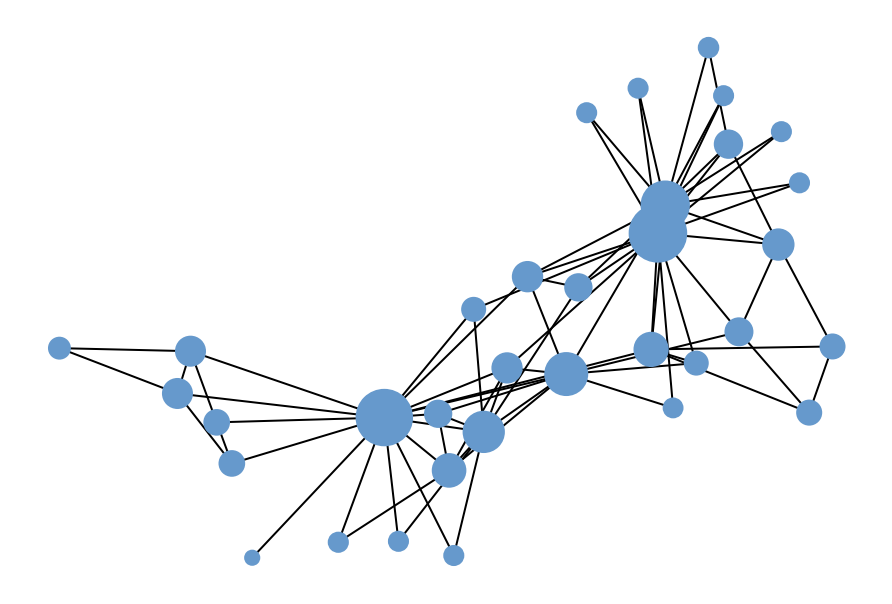

In [7]:
# plotting the graph 
cent = np.array(list(nx.pagerank(Gk).values()))
scaler = MinMaxScaler((50,800))
scaledC = scaler.fit_transform(cent[:,np.newaxis])
nx.draw(Gk, node_size=scaledC, pos=pos, node_color='#6699cc')

Because this graph is undirected, the pagerank of a node is just proportional to its degree.

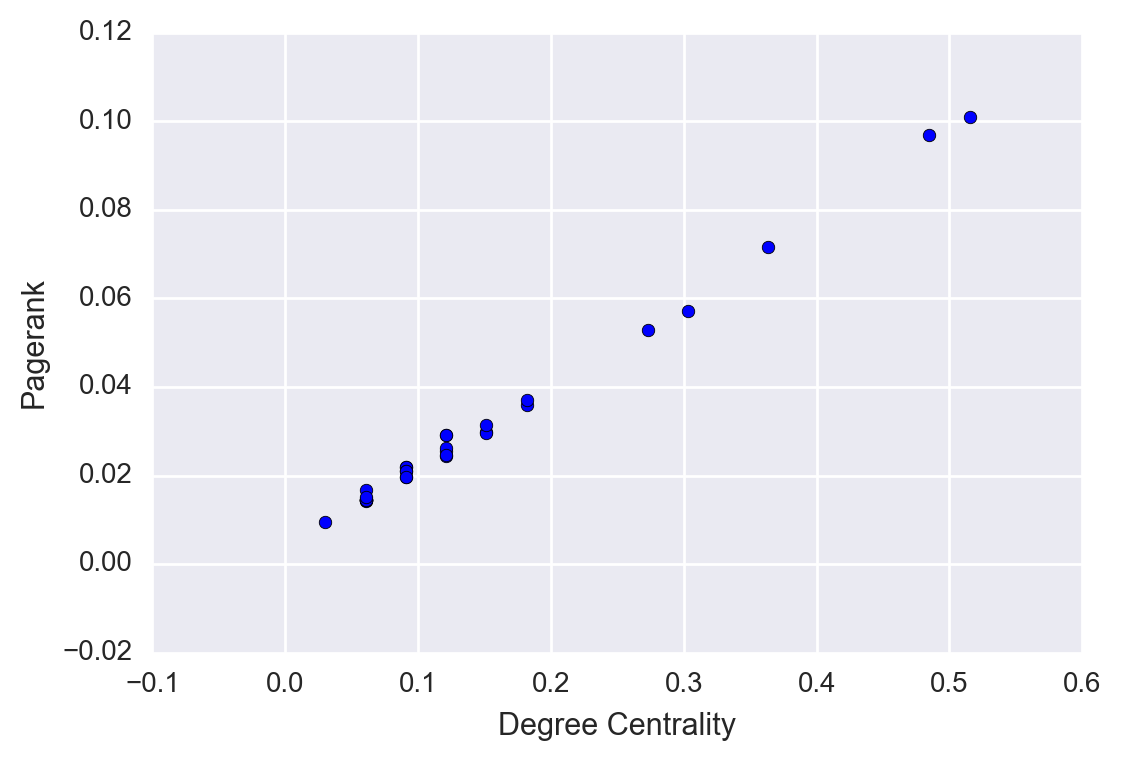

In [21]:
degree_c = np.array(list(nx.degree_centrality(Gk).values()))
plt.scatter(degree_c, cent)
plt.xlabel('Degree Centrality')
plt.ylabel('Pagerank')

To study a more interesting directed graph, we can look at the nervous system of the flatworm (_C. elegans_):

In [16]:
G = nx.read_gml('data/celegansneural.gml')
scc = nx.strongly_connected_component_subgraphs(G)
sizes = [(g,len(g)) for g in scc]
largestG = max(sizes, key = lambda x: x[1])[0]

In [17]:
Gmax = nx.DiGraph(largestG)
degree_c = nx.degree_centrality(Gmax)
pagerank_c = nx.pagerank(Gmax)
eigenvector_c = nx.eigenvector_centrality(Gmax)

In [18]:
n = len(Gmax.nodes())
deg = np.zeros(n)
pr = np.zeros(n)
eig = np.zeros(n)
bw = np.zeros(n)
i=0
for node in Gmax:
    deg[i] = degree_c[node]
    pr[i] = pagerank_c[node]
    eig[i] = eigenvector_c[node]
    i+=1
measures = pd.DataFrame()
measures['nodes'] = Gmax.nodes()
measures.set_index(['nodes'], inplace=True)
measures['eigenvector_c'] = pd.DataFrame.from_dict(eigenvector_c, orient='index')
measures['pagerank_c'] = pd.DataFrame.from_dict(pagerank_c, orient='index')
measures['degree_c'] = pd.DataFrame.from_dict(degree_c, orient='index')

/Users/evimaria/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/evimaria/opt/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


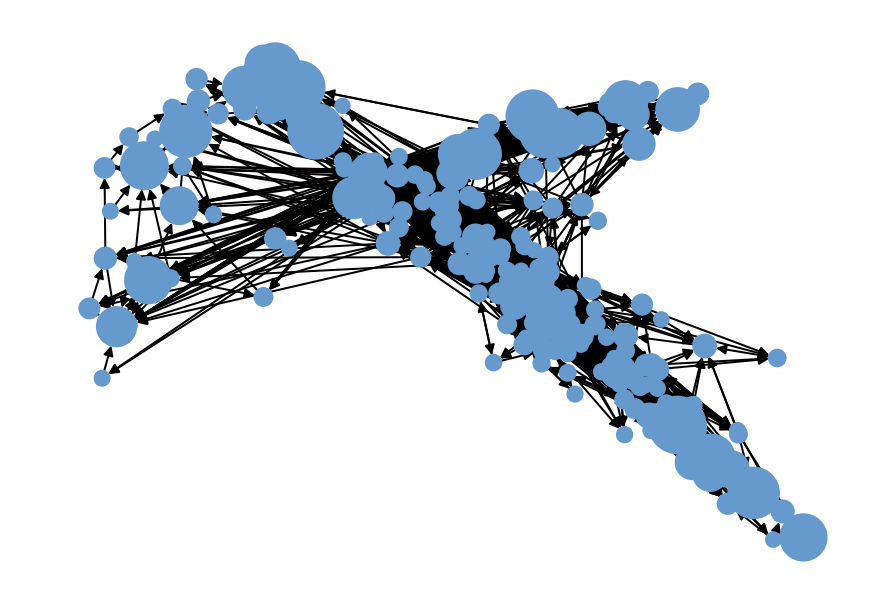

In [19]:
# plotting the graph 
cent = np.array(list(nx.pagerank(Gmax).values()))
scaler = MinMaxScaler((50,800))
scaledC = scaler.fit_transform(cent[:,np.newaxis])
nx.draw(Gmax, node_size=scaledC, node_color='#6699cc')

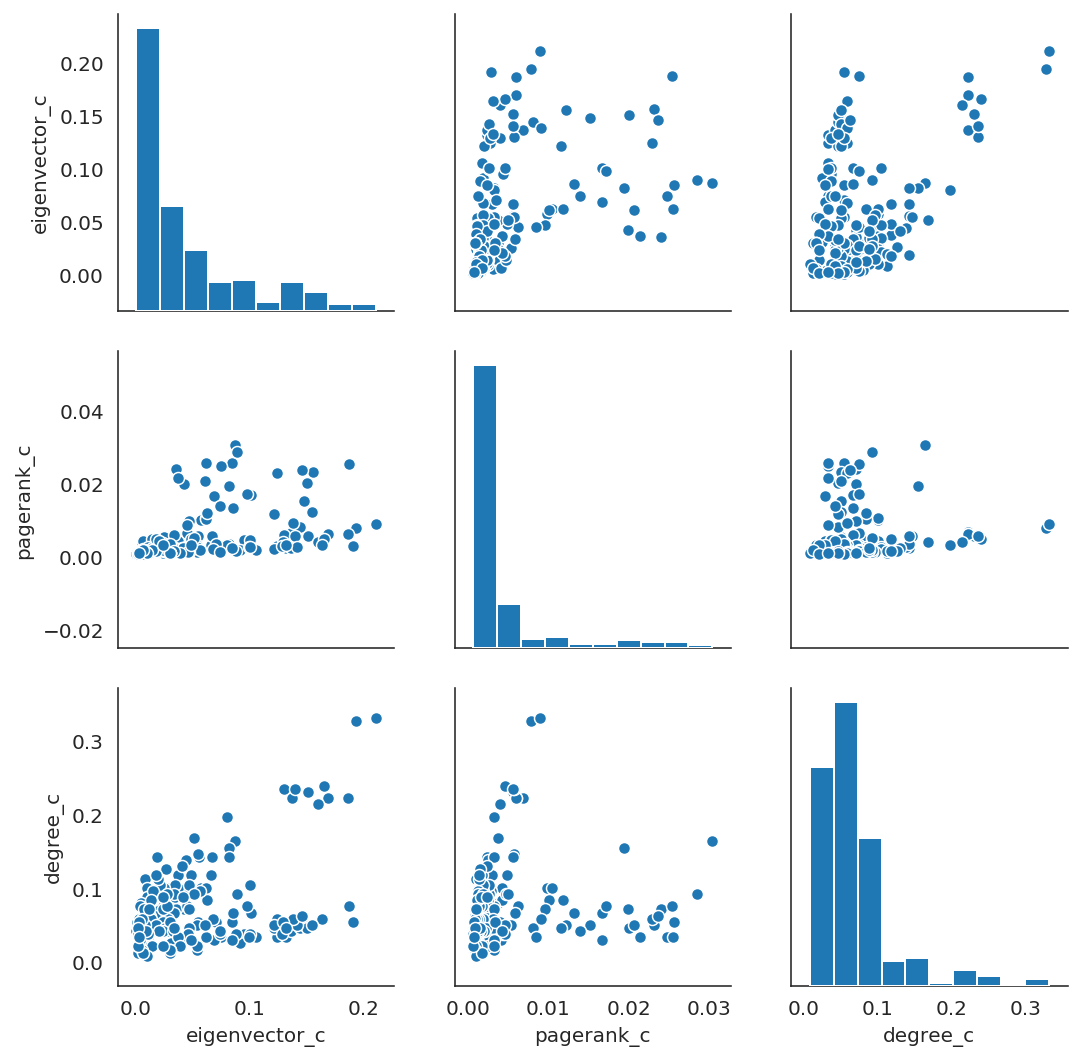

In [13]:
with sns.axes_style('white'):
    sns.pairplot(measures)   

## Computing PageRank: the Power Method

From a mathematical standpoint, we are done!  

However, from a Computer Science standpoint, there are still some issues.

The most significant issue is simply this: PageRank results must be provided __very quickly.__   Search engines are in competition and speed is a competitive advantage.

Here is an example Google search:

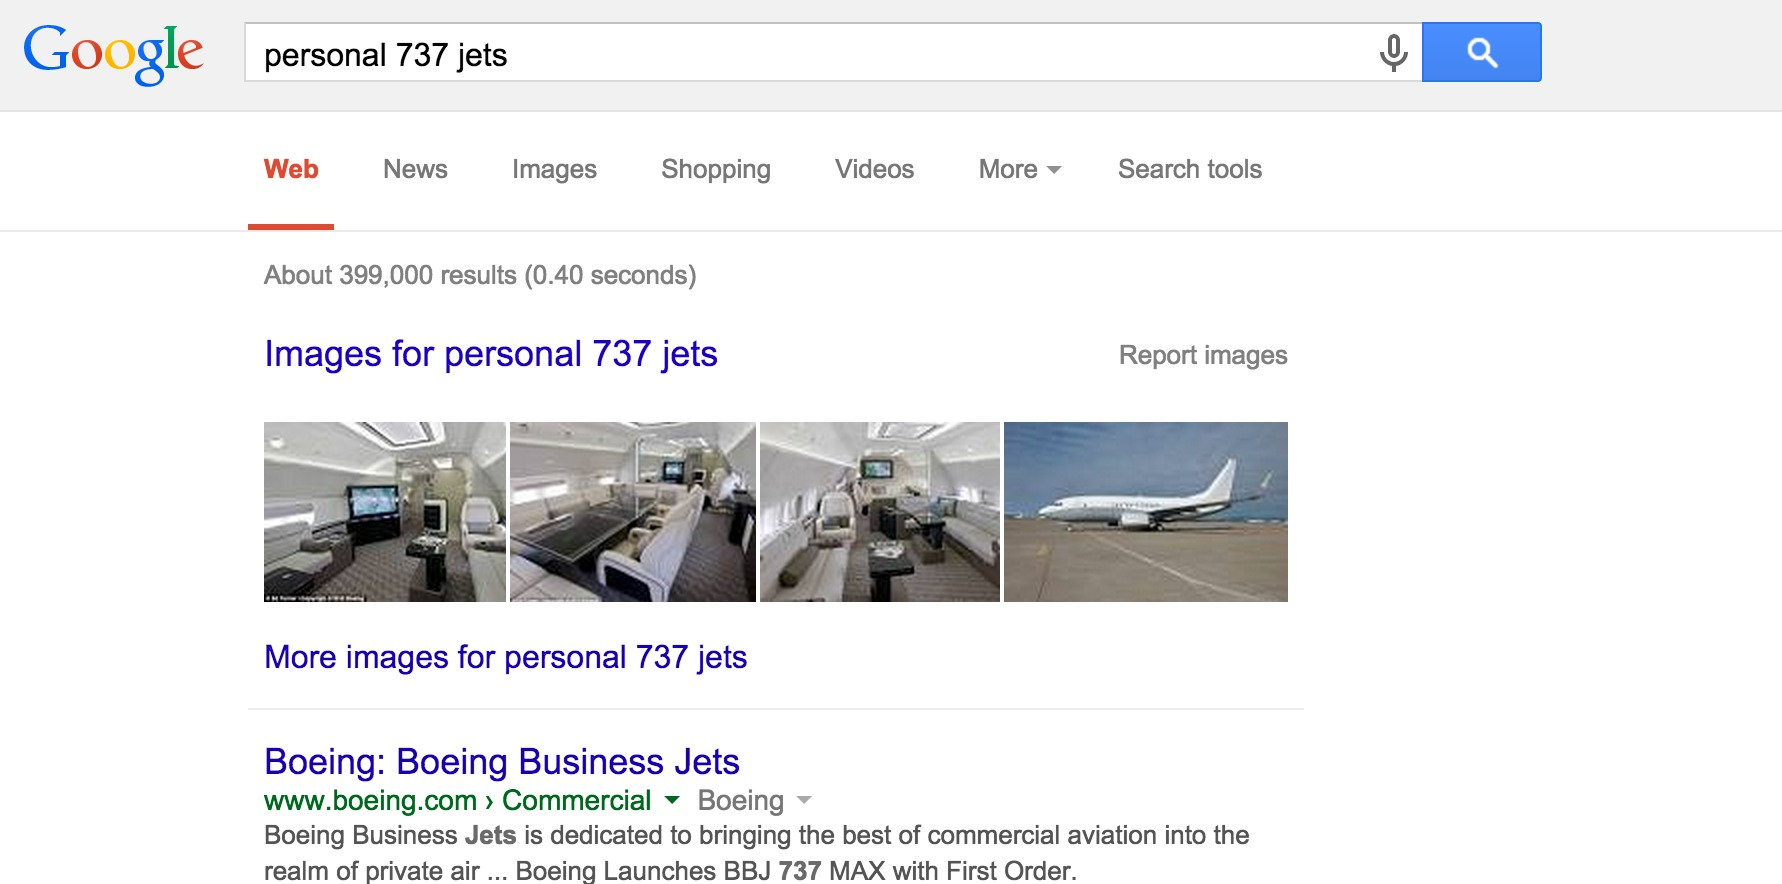

In [27]:
sl.hide_code_in_slideshow()
display(Image("figs/sample-google-search.jpg", width=1000))

Notice that the search returned about 400,000 results!

Recall that using Gaussian elimination to solve $A\vx = \vb$ takes about $\frac{2}{3}n^3$ operations.

In this case, apparently $n = 400,000.$  

So computing the PageRank in the straightforward way we've described would take about 42,667,000,000,000,000 operations.  

Assuming a 2GHz CPU, that's on the order of __eight months.__

In [28]:
((2./3)*(400000**3))/((2*10**9)*(3600*24*30))

8.23045267489712

We need a faster way to compute the PageRank!

Here is an important point: we only need the __principal__ eigenvector. (The one corresponding to $\lambda = 1$).

Let's review how a Markov chain gets to steady state.  As we discussed at the end of the lecture on the characteristic equation, the state of the chain at any step $k$ is given by

$${\bf x_k} = c_1{\bf v_1}\lambda_1^k + c_2{\bf v_2}\lambda_2^k + \dots + c_n{\bf v_n}\lambda_n^k.$$

Let's assume that $\lambda_1$ is the eigenvalue 1.  If the chain converges to steady sate, then we know that all eigenvalues other than $\lambda_1$ are less than 1 in magnitude.

Of course, if $|\lambda_i| < 1,$ $$\lim_{k\rightarrow\infty} \lambda_i^k = 0.$$

So:

$$\lim_{k\rightarrow\infty}{\bf x_k} = c_1{\bf v_1}.$$

Note that $c_1$ is just a constant that doesn't affect the relative sizes of the components of ${\vx_k}$ in the limit of large $k.$

This is another way of stating that the Markov chain goes to steady state __no matter what the starting state is.__

An alternative way to compute the steady state of the chain:
    
1. Start from a __random__ state $\vx_0$.
2. Compute $\vx_{k+1} = A\vx_k$ for $k = 0,1,2,3,\dots$

How do we know when to stop in Step 2?  

Since we are looking for steady-state, we can stop when the difference between $\vx_{k+1}$ and $\vx_k$ is small.

This is called the __power method.__

Why is this a better method?

Keep in mind that the number of flops in matrix-vector multiplication is about $2n^2$.  

This is compared to $2/3n^3$ for solving a system (finding the eigenvector directly).

Let's say that after computing
$$\vx_1 = A \vx_0$$
$$\vx_2 = A \vx_1$$
$$\vx_3 = A \vx_2$$
$$\vx_4 = A \vx_3$$
$$\vx_5 = A \vx_4$$
$$\vx_6 = A \vx_5$$
$$\vx_7 = A \vx_6$$
$$\vx_8 = A \vx_7$$
$$\vx_9 = A \vx_8$$
$$\vx_{10} = A \vx_9$$
we find that $\vx_{10}$ is sufficiently close to $\vx_9.$ 

How much work did we do?

We did 10 matrix-vector multiplications, or $20n^2$ flops.

So the power method is $$\frac{\frac{2}{3}n^3}{20n^2} = \frac{n}{30}$$ 
times faster than the direct method.

For our example, $n/30 = 13,333$.  So this trick reduces the running time from __8 months__ down to __27 minutes.__

In [29]:
20*400000.**2/((2*10**9)*(60))

26.666666666666668

In [30]:
# Given time, talk about sparse matrix-vector multiply.
# This is linear in n, with a constant equal to average degree (say 10)
# and gets the computation down to 40 milliseconds
# but that requires explaining why P is not really dense
# (it can be expressed as a sparse matrix plus a constant matrix)
20*10*400000./((2*10**9))

0.04

This is an example of an __iterative__ method.  Iterative methods are often the preferred approach for solving linear algebra problems in the real world. 

One final thing: how exactly do we decide when to stop iterating in the power method?

One simple way is to add up the differences of the components of $\vx_{k+1}-\vx_k$:

$$ s = \sum_{i=1}^n |\vx_{k+1,i} - \vx_{k,i}| $$

and compare it to the sum of the components of $\vx_k$:

$$ d = \sum_{i=1}^n |\vx_{k,i}| $$

If $s/d$ is small (say, less than 0.001) then we can conclude that $\vx_{k+1}$ is close enough to $\vx_k$ for us to stop iterating.

So the power method is fast, making it the algorithm of choice for a company like Google.  It is also easy to implement, and easy to parallelize across multiple machines.